In [1]:
#OCR Notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# Path to the data directory
data_dir = Path("./datasetOCR/level_5/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  6992
Number of labels found:  6992
Number of unique characters:  10
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [3]:

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


In [4]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

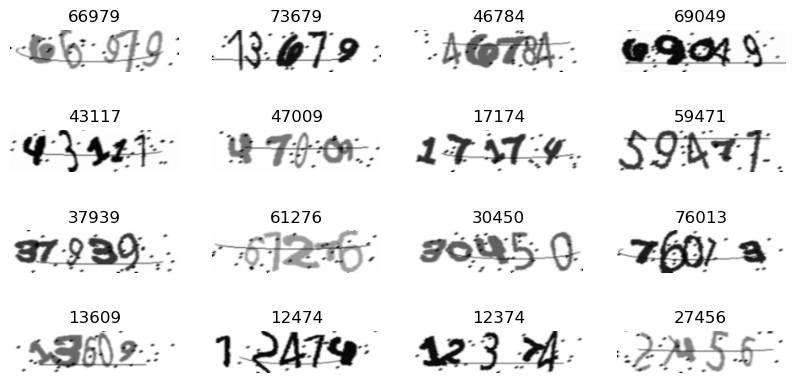

In [5]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [6]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation=tf.nn.softmax, name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [6]:
# Record start time
start_time = time.time()
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
394/394 [==============================] - 47s 110ms/step - loss: 13.7396 - val_loss: 12.8403
Epoch 2/100
394/394 [==============================] - 42s 106ms/step - loss: 12.7856 - val_loss: 12.7697
Epoch 3/100
394/394 [==============================] - 44s 112ms/step - loss: 12.7318 - val_loss: 12.6678
Epoch 4/100
394/394 [==============================] - 42s 107ms/step - loss: 12.6161 - val_loss: 12.5768
Epoch 5/100
394/394 [==============================] - 42s 107ms/step - loss: 12.5424 - val_loss: 12.5016
Epoch 6/100
394/394 [==============================] - 41s 105ms/step - loss: 12.5072 - val_loss: 12.4749
Epoch 7/100
394/394 [==============================] - 41s 104ms/step - loss: 12.4487 - val_loss: 12.2865
Epoch 8/100
394/394 [==============================] - 42s 107ms/step - loss: 11.3506 - val_loss: 11.1924
Epoch 9/100
394/394 [==============================] - 41s 105ms/step - loss: 11.1837 - val_loss: 11.1744
Epoch 10/100
394/394 [========================

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\demba\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\demba\AppData\Local\Temp\ipykernel_19116\491005725.py", line 11, in <module>
    history = model.fit(
  File "C:\Users\demba\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\demba\anaconda3\lib\site-packages\keras\engine\training.py", line 1650, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\demba\anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\demba\anaconda3\lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 880, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\demba\anaconda3\lib\site-packages\tensorflow\pyt

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, : max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Let's check results on some validation samples
total_preds = 0
total_correct_preds = 0
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        pred_title = f"Prediction: {pred_texts[i]}"
        real_title = f"Real: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(f"{pred_title}\n{real_title}")
        ax[i // 4, i % 4].axis("off")
        
        # Count the number of correct predictions
        if pred_texts[i] == orig_texts[i]:
            total_correct_preds += 1
            
        total_preds += 1
        
plt.show()
# Record end time
end_time = time.time()
elapsed_time = end_time - start_time

# Convert elapsed time to minutes
elapsed_time_minutes = elapsed_time / 60

print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

# Print the total number of predictions, the number of correct predictions, and the number of wrong predictions
total_wrong_preds = total_preds - total_correct_preds
print(f"\nTotal predictions: {total_preds}")
print(f"Correct predictions: {total_correct_preds}")
print(f"Wrong predictions: {total_wrong_preds}")

accuracy = (total_correct_preds / total_preds) * 100
print(f"\nAccuracy: {accuracy:.4f}%")


In [ ]:
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
     
        
        # Count the number of correct predictions
        if pred_texts[i] == orig_texts[i]:
            total_correct_preds += 1
        else:
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            pred_title = f"Prediction: {pred_texts[i]}"
            real_title = f"Real: {orig_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(f"{pred_title}\n{real_title}\n\n")
            ax[i // 4, i % 4].axis("off")
            
        total_preds += 1
        
        # Print only the wrong predictions
        if pred_texts[i] != orig_texts[i]:
            print(f"Predicted: {pred_texts[i]}")
            print(f"Original: {orig_texts[i]}")
            print("----------------------")
            
    plt.show()
